## パッケージ導入

In [ ]:
!pip install --upgrade google-cloud-aiplatform japanize_matplotlib

In [ ]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

## 事前準備

In [1]:
import os, json, datetime, pprint
import numpy as np

from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import japanize_matplotlib

import vertexai
import vertexai.preview.generative_models as generative_models
from vertexai.preview.generative_models import GenerativeModel, Part
from vertexai.preview import caching

In [2]:
PROJECT_ID = !gcloud config get-value project
PROJECT_ID = PROJECT_ID[-1]
vertexai.init(project=PROJECT_ID, location='us-central1')

BUCKET = f'gs://{PROJECT_ID}-handson'

model_pro = GenerativeModel('gemini-1.5-pro')
model_flash = GenerativeModel('gemini-1.5-flash')

In [3]:
def create_cached_model(movie_file, model_name='gemini-1.5-pro-001', ttl=60):
    prompt_cached = [
        '[movie file]',
        Part.from_uri(movie_file, mime_type='video/mp4'),
    ]
    cached_content = caching.CachedContent.create(
        model_name=model_name,
        contents=prompt_cached,
        ttl=datetime.timedelta(minutes=ttl)
    )
    model = GenerativeModel.from_cached_content(cached_content=cached_content)
    return model

In [4]:
def generate(prompt, model=model_pro, temperature=0.4, top_p=0.4):
    responses = model.generate_content(
        prompt,
        generation_config={
            'max_output_tokens': 8192,
            'temperature': temperature,
            'top_p': top_p
        },
        safety_settings={
            generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        },
        stream=True,
    )

    result = ''
    for response in responses:  # API からの応答をストリーミングで画面表示
        try:
            print(response.text, end='')
            result += response.text
        except Exception as e:
            print(e)
            break

    return result               # 応答全体を返却

In [5]:
def load_json(text):
    text = text.replace('```json', '').replace('```', '').replace('\n', ' ')
    return json.loads(text)

## 対象動画をキャッシング

In [6]:
!gsutil ls -l {BUCKET}/mp4/s*

  24857097  2024-09-21T01:35:04Z  gs://your-project-handson/mp4/s_Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.mp4
   5514908  2024-09-21T01:39:05Z  gs://your-project-handson/mp4/s_千葉県印西市にデータセンターを開設.mp4
  30815449  2024-09-21T01:40:53Z  gs://your-project-handson/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4
TOTAL: 3 objects, 61187454 bytes (58.35 MiB)


In [7]:
target_s = f'{BUCKET}/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4'
model = create_cached_model(target_s, ttl=300)

# ファイル名の先頭が n_ の無音動画ファイルを指定すること
target_n = f'{BUCKET}/mp4/n_大規模言語モデルを支える分散学習インフラ Pathways.mp4'
model_noaudio = create_cached_model(target_n, ttl=300)

**注意**

次のコマンドを実行するとプロジェクト内でキャッシュ中のデータをすべて削除できます。

キャッシュ中のデータに対する不要な課金を避けるために、検証が完了したら実行しておくことをお勧めします。

```
for item in caching.CachedContent.list():
    cached_content = caching.CachedContent(
        f'projects/{item.project}/locations/{item.location}/cachedContents/{item.name}')
    cached_content.delete()
```

In [44]:
filename = target_s.split('/')[-1]
basename = filename.rstrip('.mp4').lstrip('s_')
image_dir = f'{BUCKET}/image/{basename}'
gsutil_opt = '-o GSUtil:parallel_composite_upload_threshold=150M'
local_image_dir = basename

In [ ]:
# 静止画像ファイルをローカルにコピー
!gsutil -m {gsutil_opt} cp -r "{image_dir}" ./

## キャラクター抽出

In [11]:
prompt_identify_characters = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find characters in the movie and describe the visual appearance of each character as detailed as possible.
B. Identify the name of each character you found on task A. If you cannot identify the name, name it "Unknown".
C. Identify representative scenes for each character where the character visually appears on the screen.

[condition]
B. The description has more than three sentences.
C. The number of scenes for each character is at most three. Each scene is identified with timestamp mm:ss-mm:ss.

[format instruction]
In Japanese. Output is a JSON list of "character dict". "character dict" is a JSON dict in the following format:
{
  "Character ID": <Sequential number starting from 1>,
  "Name": "<Character name>",
  "Visual Description": "<Visual appearance>",
  "Scenes": [ "<list of timestamp of representative scenes>" ]
}
'''

In [12]:
result = generate(prompt_identify_characters, model=model)

[
  {
    "Character ID": 1,
    "Name": "中井悦司",
    "Visual Description": "中井悦司さんは黒のポロシャツを着て、眼鏡をかけています。彼は短髪で、黒い髪をしています。彼はアジア系の男性で、中肉中背です。",
    "Scenes": [
      "00:12-00:27",
      "00:28-00:33",
      "00:34-02:05"
    ]
  },
  {
    "Character ID": 2,
    "Name": "北瀬 公香",
    "Visual Description": "北瀬公香さんは黒のジャケットに白いTシャツを着て、眼鏡をかけています。彼は短髪で、黒い髪をしています。彼はアジア系の男性で、中肉中背です。",
    "Scenes": [
      "18:24-18:37",
      "18:38-19:11",
      "19:14-19:22"
    ]
  }
]

=====
1 中井悦司 中井悦司さんは黒のポロシャツを着て、眼鏡をかけています。彼は短髪で、黒い髪をしています。彼はアジア系の男性で、中肉中背です。


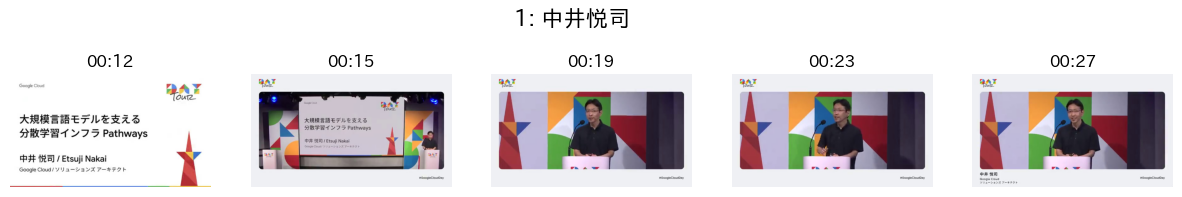

<Figure size 640x480 with 0 Axes>

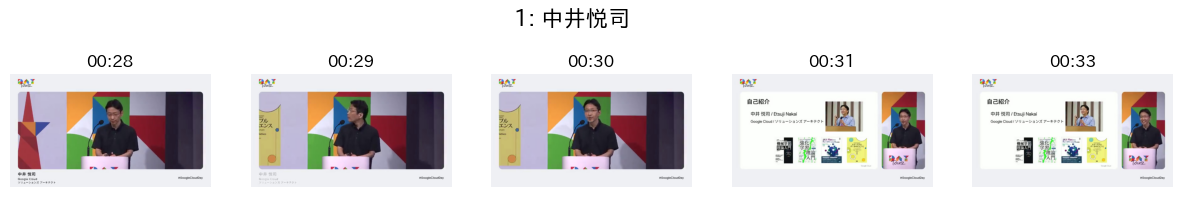

<Figure size 640x480 with 0 Axes>

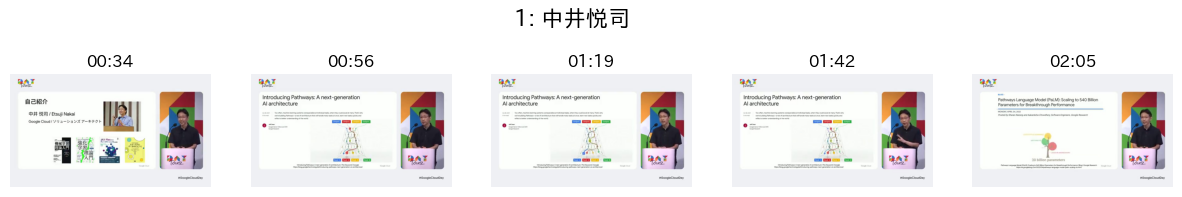

=====
2 北瀬 公香 北瀬公香さんは黒のジャケットに白いTシャツを着て、眼鏡をかけています。彼は短髪で、黒い髪をしています。彼はアジア系の男性で、中肉中背です。


<Figure size 640x480 with 0 Axes>

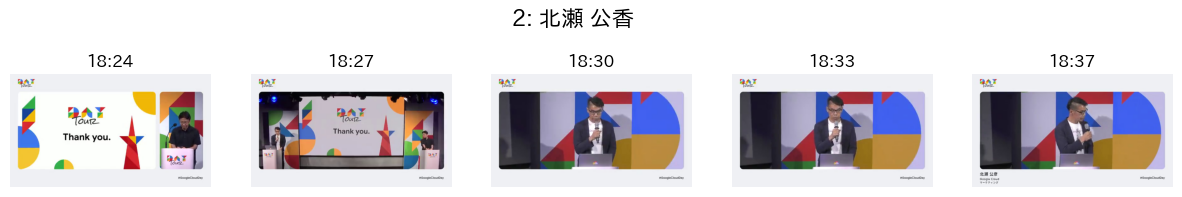

<Figure size 640x480 with 0 Axes>

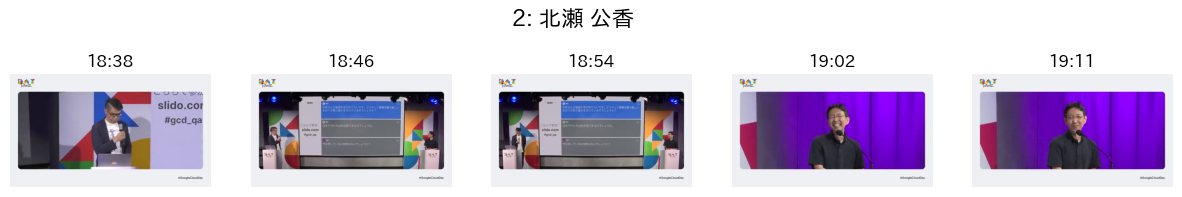

<Figure size 640x480 with 0 Axes>

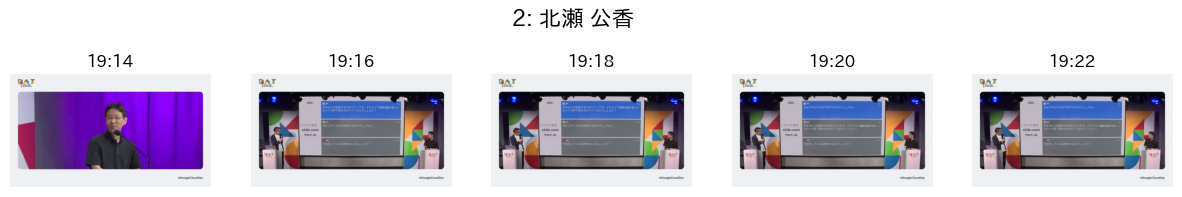

<Figure size 640x480 with 0 Axes>

In [13]:
scenes = load_json(result)
jpg_files = !ls "{local_image_dir}/"
m = 0
for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
    try:
        m = max(m, int(c))
    except:
        pass

for item in scenes:
    print('=====')
    print(item['Character ID'], item['Name'], item['Visual Description'])
    for ts in item['Scenes'][:3]:
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2.5))  # Adjust figsize as needed
        axs = axs.ravel()
        fig.suptitle(str(item['Character ID']) + ': ' + item['Name'], fontsize=16)
        for c, ts in enumerate(np.linspace(max(1, ss1), min(ss2, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

キャラクター名はハルシネーションが起きている可能性があるので、外見の記述と参考画像を元にネット検索で正しい名前を検索して、参照用画像ファイルを別途用意

In [27]:
chars = !gsutil ls "{image_dir}/characters/*.png"
chars

['gs://your-project-handson/image/大規模言語モデルを支える分散学習インフラ Pathways/characters/中井 悦司.png',
 'gs://your-project-handson/image/大規模言語モデルを支える分散学習インフラ Pathways/characters/北瀬 公彦.png']

In [28]:
prompt_reference = [
    '\n[Reference information to identify character names]'
]
image_files = {}
for item in chars:
    name = item.split('/')[-1].rstrip('.png')
    image_files[name] = item
    prompt_reference += [
        f'The name of following character is "{name}"',
        Part.from_uri(uri=image_files[name], mime_type='image/png')
    ]

prompt_reference

['\n[Reference information to identify character names]',
 'The name of following character is "中井 悦司"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://your-project-handson/image/\345\244\247\350\246\217\346\250\241\350\250\200\350\252\236\343\203\242\343\203\206\343\202\231\343\203\253\343\202\222\346\224\257\343\201\210\343\202\213\345\210\206\346\225\243\345\255\246\347\277\222\343\202\244\343\203\263\343\203\225\343\203\251 Pathways/characters/\344\270\255\344\272\225 \346\202\246\345\217\270.png"
 },
 'The name of following character is "北瀬 公彦"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://your-project-handson/image/\345\244\247\350\246\217\346\250\241\350\250\200\350\252\236\343\203\242\343\203\206\343\202\231\343\203\253\343\202\222\346\224\257\343\201\210\343\202\213\345\210\206\346\225\243\345\255\246\347\277\222\343\202\244\343\203\263\343\203\225\343\203\251 Pathways/characters/\345\214\227\347\200\254 \345\205\254\345\275\246.png"
 }]

## 動画サマリー

In [29]:
prompt_summary = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Give an one sentence summary of the movie that can be used as a title of the movie.
B. Summarize the content of the movie in five to ten sentences.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
A, B. The output should be based on the objective information in the movie.

[format instruction]
In Japanese. In the JSON dict with the following format:
{
  "Title": "<Output of Task A>",
  "Summary": "<Output of Task B>"
}
'''

prompt_summary = [prompt_summary] + prompt_reference

In [30]:
result = generate(prompt_summary, model=model)

{
  "Title": "大規模言語モデルを支える分散学習インフラPathways",
  "Summary": "Google Cloud のソリューションズアーキテクトである中井 悦司氏は、大規模言語モデルを支える分散学習インフラPathwaysについて解説しました。中井 悦司氏は、従来の機械学習モデルはシングルモーダル、シングルタスクであったのに対し、Pathwaysはマルチモーダル、マルチタスクであると説明しました。中井 悦司氏は、Pathwaysのアイデアが生まれた背景として、2012年にGoogleのJeff Dean氏が発表したディープラーニングに関する研究成果を紹介しました。この研究成果により、ニューラルネットワークのサイズを大きくすればするほど性能が向上することが示されました。中井 悦司氏は、マルチモーダルなモデルの例として、自然言語で文章を入力すると、その文章にマッチした画像を生成する画像生成モデルを紹介しました。中井 悦司氏は、マルチモーダルに対応したモデルの仕組みとして、入力データの形式に合わせて個別に前処理を行い、意味を表す抽象的な潜在空間のベクトルに変換することを説明しました。中井 悦司氏は、Pathwaysの実現に向けた技術開発として、Googleが開発したTPUを用いた分散学習システムを紹介しました。中井 悦司氏は、Pathwaysが今後、生成系AIやマルチモーダル、マルチタスクなモデルの学習に利用できるようになると期待されると述べました。最後に、Google Cloud マーケティングの北瀬 公彦氏が登壇し、質疑応答が行われました。北瀬 公彦氏は、GKEでTPU Podを利用できるかどうか、現在注目しているAI技術は何か、プロンプトチューニングはモデルそのものをチューニングしているわけではないか、今後モデルのサイズを圧縮する技術が発展しても、やはり大規模なモデルは必要なのか、といった質問に対して、中井 悦司氏が回答しました。"
}

In [31]:
summary = pprint.pformat(load_json(result))

## 重要シーン抽出

In [32]:
prompt_important_scenes = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find around 15 important scenes in the movie with accurate timestamps.
B. Give a short summary of each scene and why that scene is important.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
The [summary] section contains the summary of the entire movie.
You don't need to use the summary information to find scenes, but the result should be consistent with the summary.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task B>
Header is: Timestamp, Description

[summary]
''' + summary

prompt_important_scenes = [prompt_important_scenes] + prompt_reference

In [33]:
important_scenes = generate(prompt_important_scenes, model=model)

Timestamp, Description
00:16-00:18, Google Cloud のソリューションズアーキテクトである中井 悦司氏が自己紹介をしています。
00:21-00:26, 中井 悦司氏が、大規模言語モデルを支える分散学習インフラPathwaysについて約30分間お話をすることを伝えています。
00:37-01:02, 中井 悦司氏が、Pathwaysというキーワードが初めて登場したのは、2021年にGoogleの機械学習ML研究チームのトップであるJeff Dean氏が発表したブログ記事であることを説明しています。
01:03-01:10, 中井 悦司氏が、Jeff Dean氏のブログ記事では、将来の機械学習モデルのアーキテクチャについて語られており、従来の機械学習モデルはシングルモーダル、シングルタスクであったのに対し、Pathwaysはマルチモーダル、マルチタスクであると説明しています。
01:29-01:52, 中井 悦司氏が、2022年にGoogleがPathways Language Model（PaLM）という大規模自然言語モデルの開発に成功したという発表があったことを説明しています。
01:52-02:25, 中井 悦司氏が、PaLMは自然言語モデルであり、自然言語という特定の形式のデータだけを取り扱っていること、テキスト文の前半から後半を予測するという特定のタスクしかやっていないことを説明しています。
02:25-03:16, 中井 悦司氏が、PaLMはシングルモーダル、シングルタスクの機械学習モデルであり、Jeff Dean氏のブログ記事にあったマルチモーダル、マルチタスクのPathwaysとは少し違うことを説明し、なぜ自然言語モデルにPathwaysというキーワードが入っているのか、その謎を解き明かしたいと述べています。
03:22-04:16, 中井 悦司氏が、2012年にGoogle社内でディープラーニングが広く使われるようになったきっかけとなった研究成果を紹介しています。YouTubeの動画データに非常に階層の深いニューラルネットワークを適用したところ、様々な物体を認識することに成功したという研究成果です。
04:16-04:57, 中井 悦司氏が、Google社内でディープラーニングの技術があらゆるプロダクトに利

## シーン情報（ビジュアル情報）取得

In [34]:
prompt_visuals = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Split the entire movie into scenes with accurate timestamps from start to the exact end of the movie file.
B. Describe what's happening in the scene as detailed as possible.
C. Enrich the output of task B by adding visual information of not only characters but also things in the background.

[condition]
A. The length of each scene is 1 to 15 seconds.
 - Good example: 00:05-00:08, 00:05-00:18. / Bad example: 00:05-01:14 as the timestamp jumps more than 15 seconds.
B, C. Avoid using audio information to describe the scene. Describle only what you see on the screen.
B. If possible, identify the names of characters. Use the full name on every part of the output.
C. The final description is very detailed, vivid and realistic to covey all the visual information of the scene, using up to three sentences.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task C>
Header is: Timestamp, Description
'''

prompt_visuals = [prompt_visuals] + prompt_reference

In [36]:
visual_info = generate(prompt_visuals, model=model)

Timestamp, Description
00:00-00:05, 白い背景に、赤、青、黄、緑の幾何学模様で構成された「DAY」の文字が表示されます。文字の下には「Breakout」と表示され、その後「Breakout Session」と表示されます。
00:05-00:11, 白い背景に、赤、青、黄、緑の幾何学模様で構成された「DAY」の文字が表示されます。文字の右上には、同じ幾何学模様で構成された「Tour」の文字が表示されます。
00:11-00:18, 白い背景に、プレゼンテーションのタイトル「大規模言語モデルを支える分散学習インフラ Pathways」と、発表者名「中井 悦司 / Etsuji Nakai」、所属「Google Cloud / ソリューションズ アーキテクト」が表示されます。右上には、赤、青、黄、緑の幾何学模様で構成された「DAY Tour」の文字と赤い星が表示されます。
00:18-00:29, 黒いシャツを着た中井 悦司が、カラフルな幾何学模様の背景の前に立って話しています。中井 悦司の左には、白い演台があり、その側面には「DAY Tour」の文字が縦書きで書かれています。
00:29-00:34, 画面左側に中井 悦司の写真と、彼が執筆したと思われる書籍の表紙が4冊表示されています。右上には「自己紹介」という見出しと、中井 悦司の名前（日本語と英語表記）、所属「Google Cloud / ソリューションズ アーキテクト」が表示されています。
00:34-01:02, 黒いシャツを着た中井 悦司が、カラフルな幾何学模様の背景の前に立って話しています。中井 悦司の左には、白い演台があり、その側面には「DAY Tour」の文字が縦書きで書かれています。
01:02-01:52, 黒いシャツを着た中井 悦司が、カラフルな幾何学模様の背景の前に立って話しています。中井 悦司の左には、白い演台があり、その側面には「DAY Tour」の文字が縦書きで書かれています。
01:52-02:14, 黒いシャツを着た中井 悦司が、カラフルな幾何学模様の背景の前に立って話しています。中井 悦司の左には、白い演台があり、その側面には「DAY Tour」の文字が縦書きで書かれています。
02:14-02:29, 黒いシャツを着た中井 悦司が、カラフルな幾何

## 音声文字起こし

In [37]:
prompt_transcription = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Transcript what they are speaking with accurate timestamps.

[condition]
A. Process the entire movie from start to the exact end of the movie file.
A. Identify the name of person who is speaking for each speech. Use the full name on every part of the output. If you cannot identify the name, name it "Unknown".

[format instruction]
In Japanese. Output is a JSON list of "speech dict". "speech dict" is a JSON dict in the following format:
{
  "timestamp": "<mm:ss-mm:ss>",
  "Name": "<Name of the speaker>",
  "Transcription": "<Transcription>"
}
'''

In [38]:
result = generate([prompt_transcription] + prompt_reference, model=model)

[
  {
    "timestamp": "00:14-00:26",
    "Name": "中井 悦司",
    "Transcription": "はい 皆さん こんにちは Google Cloud ソリューションズ アーキテクト の 中井 です え 今日 私 の 方 から は こちら の タイトル で ま 約 30 分間 お 話 を さ せ て いただき ます よろしく お 願い いたし ます"
  },
  {
    "timestamp": "00:28-00:33",
    "Name": "中井 悦司",
    "Transcription": "はい で こちら いつも の 自己 紹介 スライド です ね よろしく お 願い いたし ます"
  },
  {
    "timestamp": "00:34-01:02",
    "Name": "中井 悦司",
    "Transcription": "で 早速 中身 の 方 入っ て いき たい と 思い ます が 今日 私 の セッション の タイトル の 中 に パスウェイズ と いう キーワード が あり まし た この キーワード 皆さん 聞い た こと あり ます でしょう か え 実 は パスウェイズ と いう 言葉 が 初めて 登場 し た の が こちら の ブログ 記事 な ん です ね 2021 年 2 年 前 に え Google の え 機械 学習 ML 研究 チーム の トップ です ね ジェフ ディーン が 発表 し た ブログ 記事 に なり ます で この ブログ の 中 で ジェフ ディーン は ま 今後 の 将来 の 機械 学習 モデル の アーキテクチャ を 語っ て いる ん です ね 従来 の 機械 学習 モデル と いう の は 基本 的 に は え シングル モデル シングル タスク 何 か 特定 の 形式 の データ だけ を 扱っ て 何 か 特定 の タスク 特定 の 仕事 を する ため に ま 専用 に えっと チューニング さ れ た 開発 さ れ た モデル と いう の が 基本 でし た"
  },
  {
    "timestamp": "01:30-01:52",
    "Name": "中井 悦司",
  

In [39]:
transcription = pprint.pformat(load_json(result))

## テキスト情報取得

１回の処理ですべてのテキストを取得しようとすると、出力トークン数の上限に達するので、はじめにテキストが存在するシーンの情報を取得する。

In [10]:
prompt_text_layout = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Identify scenes where text strings are on the screen.
B. Describe the layout how text strings are arranged on the screen.

[conditions]
Process the entire movie from start to the exact end of the movie file.

[format instruction]
Layout description is in Japanese.
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Layout": "<layout description from Task B>"
}
'''

In [11]:
result = generate(prompt_text_layout, model=model_noaudio)

[
  {
    "Timestamp": "00:01-00:05",
    "Layout": "中央に文字列"
  },
  {
    "Timestamp": "00:05-00:12",
    "Layout": "左上に「Google Cloud」ロゴ、右上に「DAY Tour」ロゴ、中央にタイトル、中央下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "00:23-00:29",
    "Layout": "左下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "00:29-00:34",
    "Layout": "左上に「DAY Tour」ロゴ、中央に「自己紹介」、中央下に名前、左下に所属、右下にハッシュタグ、中央に人物写真、その下に書籍画像"
  },
  {
    "Timestamp": "00:34-01:53",
    "Layout": "左上に「DAY Tour」ロゴ、中央にタイトル、左下に投稿者名、左下に投稿日時、右下にハッシュタグ、中央に図、その下に説明文、右に人物写真"
  },
  {
    "Timestamp": "01:53-03:14",
    "Layout": "左上に「DAY Tour」ロゴ、右上に「BLOG」ロゴ、中央にタイトル、左下に投稿者名、左下に投稿日時、右下にハッシュタグ、中央に図、その下に説明文、右に人物写真、右下に説明文"
  },
  {
    "Timestamp": "03:14-03:21",
    "Layout": "左上に「DAY Tour」ロゴ、中央にタイトル、右下にハッシュタグ、右に人物写真"
  },
  {
    "Timestamp": "03:21-04:17",
    "Layout": "左上に「DAY Tour」ロゴ、中央にタイトル、左下に投稿者名、左下に投稿日時、右下にハッシュタグ、中央に図、その下に説明文、右に人物写真"
  },
  {
    "Timestamp": "04:17-04:28",
    "Layout": "左上に「DAY Tour」ロゴ、中央にタイトル、右上に「Used across products:」、右下にハッシュタ

In [12]:
layout_info = load_json(result)

取得した情報から５シーンごとに分割してテキストを抽出する。

In [17]:
prompt_texts = '''\
You are a video content editor. Work on the following tasks.

[task]
A. The [text layout] contains scenes where text strings are on the screen in JSON list.
Extract exact text strings from each scene by repeating the [steps].

[steps]
1. Take the next "text dict" item from the [text layout].
2. Extract text strings from the scene specified by the "Timestamp" and "Layout".
3. Output the new "text dict" that have the "Text" element. "Timestamp" and "Layout" should be the same as the original item.

[condition]
A. Output each character literaly as on the screen. Don't modify them.
A. Use a list to store multipe lines of texts instead of using the return code \\n in the extracted text strings.
A. Make sure to use double quotes "" in the output JSON.

[format instruction]
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Text": [List of text strings from Task A>],
  "Layout": "<layout description>"
}

[text layout]
'''

In [18]:
merged_result = []
for c in range(0, len(layout_info), 5):
    print(f'\n=== Scene {c} to {c+5} ===')
    prompt = prompt_texts + pprint.pformat(layout_info[c:c+5])
    # 正しい JSON が出力されないなどで処理エラーが発生した場合は3回リトライする。
    n = 0
    while n < 3:
        try:
            result = generate(prompt, model=model_noaudio)    
            merged_result += load_json(result)
            break
        except Exception as e:
            print(e)
            n += 1
            pass
texts = pprint.pformat(merged_result)


=== Scene 0 to 5 ===
```json
[
  {
    "Timestamp": "00:01-00:05",
    "Text": [
      "DAY",
      "Breakout",
      "Breakout Session"
    ],
    "Layout": "中央に文字列"
  },
  {
    "Timestamp": "00:05-00:12",
    "Text": [
      "Google Cloud",
      "DAY",
      "Tour",
      "大規模言語モデルを支える",
      "分散学習インフラ Pathways",
      "中井 悦司 / Etsuji Nakai",
      "Google Cloud / ソリューションズ アーキテクト",
      "#GoogleCloudDay"
    ],
    "Layout": "左上に「Google Cloud」ロゴ、右上に「DAY Tour」ロゴ、中央にタイトル、中央下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "00:23-00:29",
    "Text": [
      "中井 悦司",
      "Google Cloud",
      "ソリューションズ アーキテクト",
      "#GoogleCloudDay"
    ],
    "Layout": "左下に名前、左下に所属、右下にハッシュタグ"
  },
  {
    "Timestamp": "00:29-00:34",
    "Text": [
      "DAY",
      "Tour",
      "自己紹介",
      "中井 悦司 / Etsuji Nakai",
      "Google Cloud / ソリューションズ アーキテクト",
      "Google Cloud",
      "#GoogleCloudDay"
    ],
    "Layout": "左上に「DAY Tour」ロゴ、中央に「自己紹介」、中央下に名前、左下に所属、右下にハッシュタグ、中央に人物写真、その下に書籍画像"
  },
  {

## テキストベースの動画内検索

In [40]:
prompt_content_search = '''
You are a video content editor.

Given the following information of a movie:
- The [summary] section contains the summary of the movie.
- The [important scenes] section contains the important scenes of the movie with timestamps.
- The [visual info] section contains the visual information on what's happening in each scene with timestamps.
- The [transcription] section contains speech transcription with timestamps.
- The [text] section contains text information with timestamps.

Find one to three scenes that matches the user query with timestamps.

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>",
  "Evidence": [<List of data snippets that support your result>]
}}

[user query]
{}

[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}
'''

In [41]:
def show_thumbnails(scenes):
    jpg_files = !ls "{local_image_dir}/"
    m = 0
    for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
        try:
            m = max(m, int(c))
        except:
            pass
    for item in scenes:
        ts = item['Timestamp']
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2))  # Adjust figsize as needed
        axs = axs.ravel()
        print('=====')
        print(str(item['Description']))
        for c, ts in enumerate(np.linspace(max(1, ss1-3), min(ss2+3, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

In [42]:
%%time
query = 'ニューラルスケーリングについて解説しているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "04:57-05:58",
    "Description": "このシーンでは、中井 悦司氏がニューラルスケーリングローについて説明しています。モデルのサイズが大きいほど性能が向上するという法則であり、GPT-3とGLaMモデルの例を挙げて説明しています。",
    "Evidence": [
      "で これ 理由 は いろいろ ある ん です けど も 1 つ 分かり やすい の が やっぱり モデル の サイズ が 大きい ほど 性能 が 上がる ん です ね 実 は これ 理論 的 に は まだ 解明 さ れ て い ない ん です けど も 少なく とも 経験 的 に は 特に あの 自然 言語 を 扱う 自然 言語 モデル の 場合 は モデル の 構造 自体 が 基本 的 に 変わら なけれ ば ま とにかく その モデル に え 含ま れる パラメーター 数 を 増やせ ば 増やす ほど 性能 が 良く なる と いう こと が 知ら れ て い て え ニューラル スケーリング ロー と いう 名前 が つい て い ます",
      "で これ を 実証 する 1 つ の 事例 が こちら です ね ま ちょっと もう 今 と なっ て は 古い 話 な ん です けど も 2020 年 に GPT3 と 呼ば れる 新しい 自然 言語 モデル が 発表 さ れ て これ が ま 非常 に 性能 が いい と いう の で 話題 に なり まし た で Google の 研究 者 も これ に 負け て は なら ん と 思っ た か どう か は 分かり ませ ん が ま 翌年 また 新しい グラム モデル と いう モデル を 発表 し まし た これ 単純 に あの パラメーター の 数 だけ 比較 する と 1 桁 パラメーター が 増え て いる ん です ね で ま その 結果 と し て これ スライド で 緑 の 数字 が 出 て い ます が ま 5% ない し 10% 程度 確か に 性能 も 向上 し た 上回っ た と いう よう な 結果 に なっ て い ます ま 今 現在 あの 生成 AI の 世界 で は とにかく 大きな モデル を 

=====
このシーンでは、中井 悦司氏がニューラルスケーリングローについて説明しています。モデルのサイズが大きいほど性能が向上するという法則であり、GPT-3とGLaMモデルの例を挙げて説明しています。


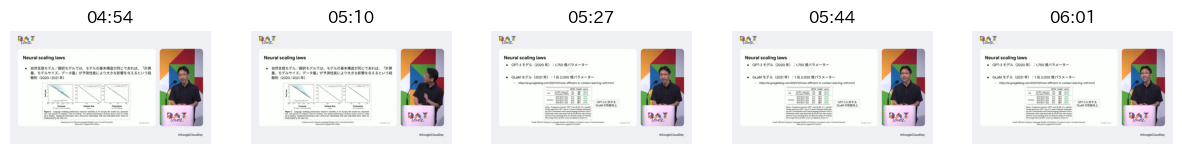

<Figure size 640x480 with 0 Axes>

In [45]:
show_thumbnails(load_json(result))

In [46]:
%%time
query = '視聴者からの質問に答えているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "18:24-18:51",
    "Description": "北瀬 公彦氏が、中井 悦司氏の勉強方法について質問しています。",
    "Evidence": [
      {
        "Name": "北瀬 公彦",
        "Transcription": "中井 さん の 勉強 方法 が 知り たい です どう やっ て 情報 収集 や 新しい もの へ の 取り組み を さ れ てる の でしょう か と いう こと です けど も 北瀬 さん",
        "timestamp": "18:24-18:37"
      },
      {
        "Visual Info": "黒いジャケットに白いTシャツを着た北瀬 公彦が、カラフルな幾何学模様の背景の前に立って話しています。北瀬 公彦の右には、白い演台があり、その側面には「DAY Tour」の文字が縦書きで書かれています。",
        "Timestamp": "18:24-18:37"
      }
    ]
  },
  {
    "Timestamp": "19:13-20:20",
    "Description": "北瀬 公彦氏が、現在注目しているAI技術は何かという質問に対して、中井 悦司氏が回答しています。",
    "Evidence": [
      {
        "Name": "北瀬 公彦",
        "Transcription": "今 注目 し て いる AI 技術 は 何 でしょう か と これ も 個人 的 な 質問 だ と 思い ます けど も いかが でしょう か",
        "timestamp": "19:13-19:18"
      },
      {
        "Name": "中井 悦司",
        "Transcription": "はい えっと ま これ あの 世の中 の 流れ 的 に は 生成 AI って 言っ とく の が 正解 だ と 思う ん です けど も あの 私 個人 的 に は 生成 AI その もの より も あの 生成 AI を どう 実用 的 に 使っ て いく か

=====
北瀬 公彦氏が、中井 悦司氏の勉強方法について質問しています。


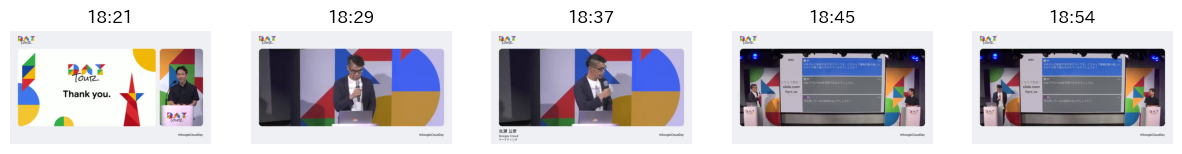

=====
北瀬 公彦氏が、現在注目しているAI技術は何かという質問に対して、中井 悦司氏が回答しています。


<Figure size 640x480 with 0 Axes>

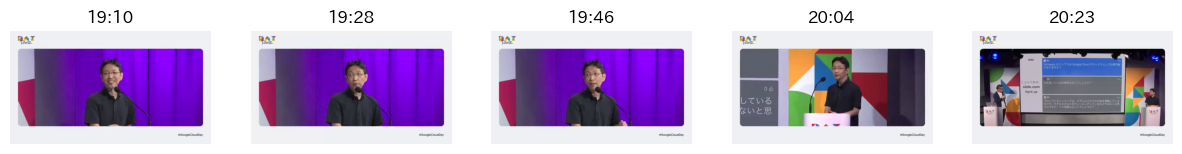

=====
北瀬 公彦氏が、プロンプトチューニングはモデルそのものをチューニングしているわけではないか、今後モデルのサイズを圧縮する技術が発展しても、やはり大規模なモデルは必要なのか、といった質問に対して、中井 悦司氏が回答しています。


<Figure size 640x480 with 0 Axes>

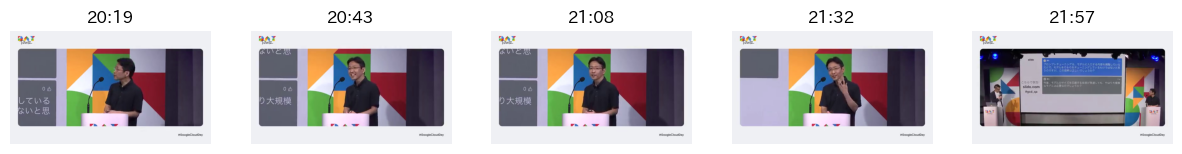

<Figure size 640x480 with 0 Axes>

In [47]:
show_thumbnails(load_json(result))

In [49]:
%%time
query = '発表者が大きく写っているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "00:11-00:18",
    "Description": "このシーンでは、発表者の名前と所属が画面に表示され、発表者が大きく写っています。",
    "Evidence": [
      "白い背景に、プレゼンテーションのタイトル「大規模言語モデルを支える分散学習インフラ Pathways」と、発表者名「中井 悦司 / Etsuji Nakai」、所属「Google Cloud / ソリューションズ アーキテクト」が表示されます。右上には、赤、青、黄、緑の幾何学模様で構成された「DAY Tour」の文字と赤い星が表示されます。"
    ]
  },
  {
    "Timestamp": "00:18-00:29",
    "Description": "このシーンでは、発表者が画面の中央に大きく写り、自己紹介をしています。",
    "Evidence": [
      "黒いシャツを着た中井 悦司が、カラフルな幾何学模様の背景の前に立って話しています。中井 悦司の左には、白い演台があり、その側面には「DAY Tour」の文字が縦書きで書かれています。"
    ]
  }
]
```CPU times: user 37.7 ms, sys: 9.39 ms, total: 47.1 ms
Wall time: 1.72 s


=====
このシーンでは、発表者の名前と所属が画面に表示され、発表者が大きく写っています。


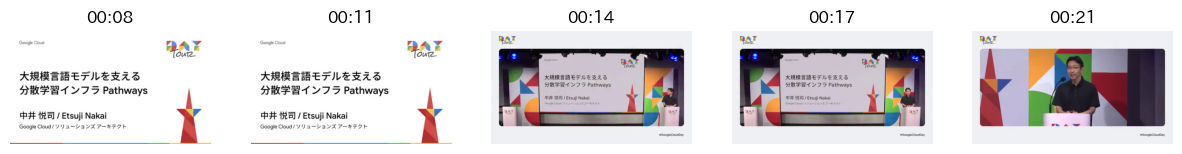

=====
このシーンでは、発表者が画面の中央に大きく写り、自己紹介をしています。


<Figure size 640x480 with 0 Axes>

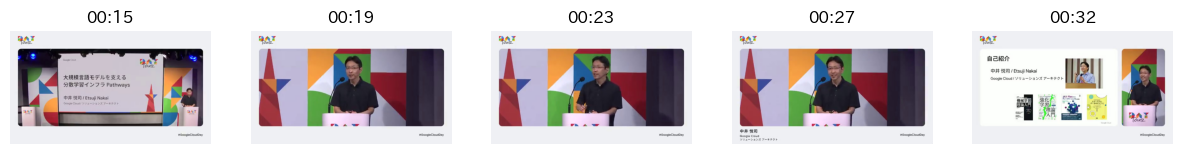

<Figure size 640x480 with 0 Axes>

In [50]:
show_thumbnails(load_json(result))

## 動画ベースの動画内検索

In [51]:
prompt_movie_content_search = '''\
You are a video content editor.
Find one to three scenes that matches the user query with timestamps.

[condition]
Try to identify names of characters.
The result should be based on the objective information in the movie itself.

[user query]
{}

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>"
}}
'''

In [52]:
%%time
query = 'ニューラルスケーリングについて解説しているシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "04:28-05:12",
    "Description": "中井さんが、機械学習モデル、ディープラーニングモデルのサイズが大きくなると性能が向上するというニューラルスケーリングについて解説しているシーンです。"
  }
]CPU times: user 68.9 ms, sys: 54.3 ms, total: 123 ms
Wall time: 22.7 s


=====
中井さんが、機械学習モデル、ディープラーニングモデルのサイズが大きくなると性能が向上するというニューラルスケーリングについて解説しているシーンです。


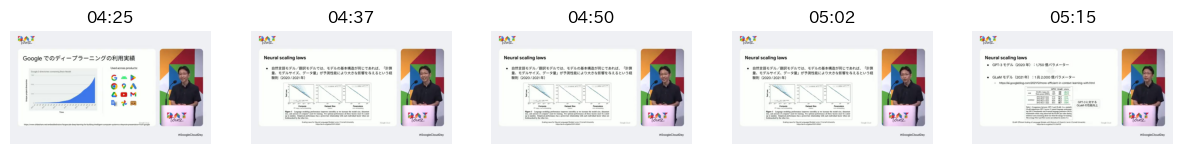

<Figure size 640x480 with 0 Axes>

In [53]:
show_thumbnails(load_json(result))

In [54]:
%%time
query = '視聴者からの質問に答えているシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "18:24-19:13",
    "Description": "中井 悦司さんが視聴者からの「中井さんの勉強方法が知りたいです。どうやって情報収集や新しいものへの取り組みをされているのでしょうか？」という質問に対して、「今日はすみません。パスさせてください。ぜひ次回のGoogle Cloud Daysで、私の勉強法のセッションを企画していただければと思います。」と回答しています。"
  },
  {
    "Timestamp": "19:16-20:20",
    "Description": "中井 悦司さんが視聴者からの「GKEでTPU Podを利用できるのでしょうか。」という質問に対して、「現状ではTPU PodをダイレクトにGKEにアサインするっていうのはなかった気がしますね。ベアメタルTPU PodをGoogle Cloud上で用意して、GKEからタスクを投げるっていうのはもちろんできますが、GKEとダイレクトなインテグレーションは、すみません。私の知る範囲ではまだなかったと思います。」と回答しています。"
  },
  {
    "Timestamp": "20:22-22:53",
    "Description": "北瀬 公彦さんが視聴者からの「今注目しているAI技術はなんでしょうか？」という質問に対して、中井 悦司さんは「世の中の流れ的には生成AIって言っとくのが正解だと思うんですけども、私個人的には生成AIそのものよりも、生成AIをどう実用的に使っていくかっていう、えっと、アーキテクチャの方に興味がありますね。生成AI単体で使ってもあんまり実用的なことって、えっと、できること限られてるんですね。おそらく他の技術と生成AIを組み合わせる、組み合わせパターンっていうのが重要になるので、ちょっとそういう組み合わせが今後どういう組み合わせが出てくるのか、出てくるのか、ちょっと注目しています。」と回答しています。続けて、北瀬 公彦さんが視聴者からの「今後、モデルのサイズを圧縮する技術が発達しても、やはり大規模なモデルは必要なのでしょうか？」という質問に対して、中井 悦司さんは「はい、ありがとうございます。これいい質問だと思いますが、基本的に私は必要だと思っています。というのは、モデルを圧縮する

=====
中井 悦司さんが視聴者からの「中井さんの勉強方法が知りたいです。どうやって情報収集や新しいものへの取り組みをされているのでしょうか？」という質問に対して、「今日はすみません。パスさせてください。ぜひ次回のGoogle Cloud Daysで、私の勉強法のセッションを企画していただければと思います。」と回答しています。


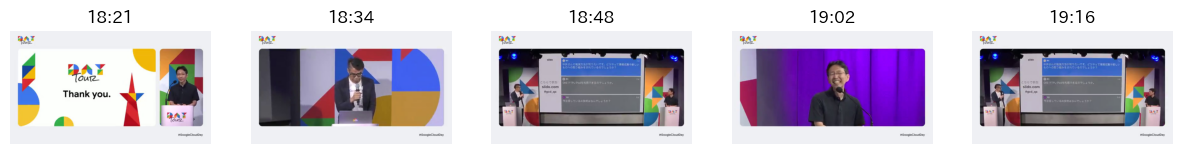

=====
中井 悦司さんが視聴者からの「GKEでTPU Podを利用できるのでしょうか。」という質問に対して、「現状ではTPU PodをダイレクトにGKEにアサインするっていうのはなかった気がしますね。ベアメタルTPU PodをGoogle Cloud上で用意して、GKEからタスクを投げるっていうのはもちろんできますが、GKEとダイレクトなインテグレーションは、すみません。私の知る範囲ではまだなかったと思います。」と回答しています。


<Figure size 640x480 with 0 Axes>

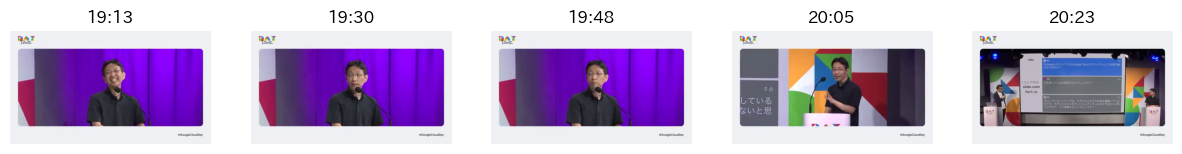

=====
北瀬 公彦さんが視聴者からの「今注目しているAI技術はなんでしょうか？」という質問に対して、中井 悦司さんは「世の中の流れ的には生成AIって言っとくのが正解だと思うんですけども、私個人的には生成AIそのものよりも、生成AIをどう実用的に使っていくかっていう、えっと、アーキテクチャの方に興味がありますね。生成AI単体で使ってもあんまり実用的なことって、えっと、できること限られてるんですね。おそらく他の技術と生成AIを組み合わせる、組み合わせパターンっていうのが重要になるので、ちょっとそういう組み合わせが今後どういう組み合わせが出てくるのか、出てくるのか、ちょっと注目しています。」と回答しています。続けて、北瀬 公彦さんが視聴者からの「今後、モデルのサイズを圧縮する技術が発達しても、やはり大規模なモデルは必要なのでしょうか？」という質問に対して、中井 悦司さんは「はい、ありがとうございます。これいい質問だと思いますが、基本的に私は必要だと思っています。というのは、モデルを圧縮する技術というのはあくまで圧縮する技術なので、圧縮する元になる、え、大規模なモデルっていうのはやっぱり誰かが作る必要があるんですよね。それを、一般ユーザーが自分で作るっていう場面はあんまりないかと思いますが、えっと、やはり大規模な分散インフラを持っている、え、企業が、まずは大規模な新しいモデルをどんどんどんどん作って行って、で、それをまた圧縮する技術を組み合わせて個人でも利用ができるような簡単に利用できる環境が、え、整っていく、そんな流れは今後も続くじゃないのかなと思っています。」と回答しています。


<Figure size 640x480 with 0 Axes>

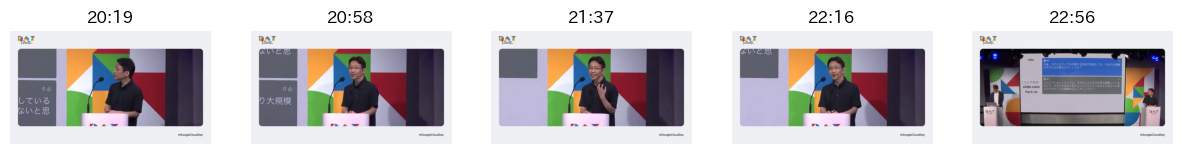

<Figure size 640x480 with 0 Axes>

In [55]:
show_thumbnails(load_json(result))

In [56]:
%%time
query = '発表者が大きく写っているシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "00:12-00:27",
    "Description": "中井 悦司さんが壇上で大きく写っています。"
  },
  {
    "Timestamp": "18:27-18:33",
    "Description": "北瀬 公彦さんが壇上で大きく写っています。"
  }
]CPU times: user 68.3 ms, sys: 52.9 ms, total: 121 ms
Wall time: 21.4 s


=====
中井 悦司さんが壇上で大きく写っています。


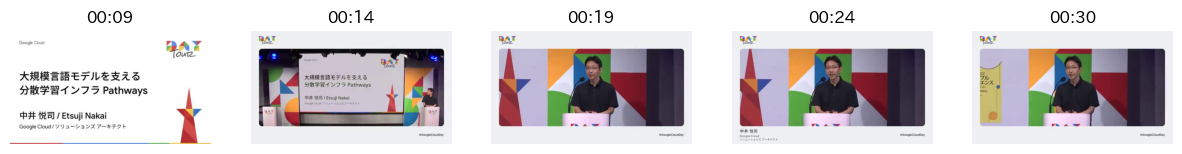

=====
北瀬 公彦さんが壇上で大きく写っています。


<Figure size 640x480 with 0 Axes>

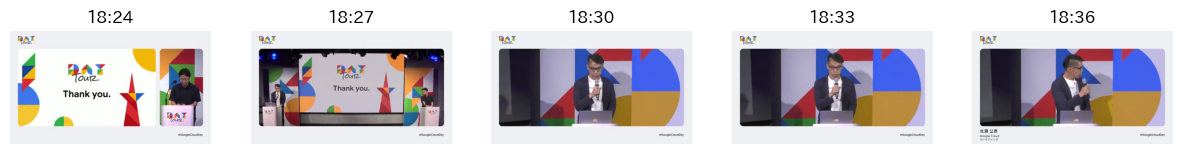

<Figure size 640x480 with 0 Axes>

In [57]:
show_thumbnails(load_json(result))

## 検索用メタテキストを保存

In [58]:
meta_text = '''\
[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}'''.format(summary, important_scenes, visual_info, transcription, texts)

metafile = f'{basename}.txt'
with open(metafile, 'w') as f:
    f.write(meta_text)

In [59]:
!gsutil cp "{metafile}" {BUCKET}/metadata/

Copying file://大規模言語モデルを支える分散学習インフラ Pathways.txt [Content-Type=text/plain]...
/ [1 files][ 81.3 KiB/ 81.3 KiB]                                                
Operation completed over 1 objects/81.3 KiB.                                     
